In this notebook, I open the galaxy redshift data from [Zhou et al.](https://doi.org/10.1093/mnras/stz1866). I filter the data and combine them into one set, to be used for the template learning. I also make plots to characterize the data, for use in the paper.

The actual data can be downloaded [here](http://d-scholarship.pitt.edu/36064/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
import copy

from modules import Galaxy, get_bandpass_dict, get_eff_wavelen

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')

## **Load the Bandpasses**

In [3]:
bandpass_dict = get_bandpass_dict('filters/')

## **Loading and trimming the data set**

Load both of the data sets, and apply quality cuts

### Deep2/3 catalog

In [5]:
cat = Table.read("data/DEEP2_uniq_Terapix_Subaru_v1.fits")
print("The Deep2/3 catalog contains",len(cat),"objects")

# quality cuts on data
uflag  = cat['u(sexflag)']
gflag  = cat['g(sexflag)']
rflag  = cat['r(sexflag)']
i2flag = cat['i2(sexflag)']
iflag  = cat['i(sexflag)']
zflag  = cat['z(sexflag)']
yflag  = cat['y(sexflag)']
cflag  = cat['flag_cfhtls']
zqual  = cat['zquality']
Class  = cat['class']

S = 4 # SExtractor flag

idx = np.where( (  uflag < S ) &
                (  gflag < S ) &
                (  rflag < S ) &
                ( i2flag < S ) &
                (  iflag < S ) &
                (  zflag < S ) &
                (  yflag < S ) &
                ( cflag == 0 ) &
                ( zqual >= 3 ) &
                ( Class == 'GALAXY' ) )

print("After quality cuts, we have",len(idx[0]),"objects")

# get the data
redshift  = cat['zhelio'][idx]

u  = cat['u_apercor'][idx]
g  = cat['g_apercor'][idx]
r  = cat['r_apercor'][idx]
i2 = cat['i2_apercor'][idx]
i  = cat['i_apercor'][idx]
z  = cat['z_apercor'][idx]
y  = cat['y_apercor'][idx]

uerr  = np.sqrt( cat['uerr_aper']**2  +  cat['uerr_apercor']**2 )[idx]
gerr  = np.sqrt( cat['gerr_aper']**2  +  cat['gerr_apercor']**2 )[idx]
rerr  = np.sqrt( cat['rerr_aper']**2  +  cat['rerr_apercor']**2 )[idx]
i2err = np.sqrt( cat['i2err_aper']**2 + cat['i2err_apercor']**2 )[idx]
ierr  = np.sqrt( cat['ierr_aper']**2  +  cat['ierr_apercor']**2 )[idx]
zerr  = np.sqrt( cat['zerr_aper']**2  +  cat['zerr_apercor']**2 )[idx]
yerr  = np.sqrt( cat['yerr_aper']**2  +  cat['yerr_apercor']**2 )[idx]

# save the data
galaxies = []
for j in range(len(redshift)):
    
    mags = np.array([u[j],g[j],r[j],i2[j],i[j],z[j],y[j]])
    errs = np.array([uerr[j],gerr[j],rerr[j],i2err[j],ierr[j],zerr[j],yerr[j]])
    filters = np.array(['u','g','r','i2','i','z','y'])
    idx = np.where( ( mags > -99 ) & ( mags < 99 ) )
    
    galaxy = Galaxy()
    galaxy.wavelen = get_eff_wavelen(bandpass_dict,filters[idx])
    galaxy.mags = mags[idx]
    galaxy.mag_err = errs[idx]
    galaxy.magToflux()
    galaxy.filters = filters[idx]
    galaxy.redshift = redshift[j]
    galaxy.source = 'DEEP2/3'
    galaxies.append(galaxy)

The Deep2/3 catalog contains 23822 objects
After quality cuts, we have 14172 objects


### HST catalog

In [6]:
cat = Table.read("data/3D-HST_Terapix_Subaru_v1.fits")
print("The HST catalog contains",len(cat),"objects")

# remove objects that are also in DEEP2/3 catalog
deep2N = cat['objno_deep2']
idx = np.where( deep2N == -99 )
cat = cat[idx]
print("There are",len(cat),"objects that aren't in Deep2/3")

# quality cuts on data
uflag  = cat['u(sexflag)']
gflag  = cat['g(sexflag)']
rflag  = cat['r(sexflag)']
i2flag = cat['i2(sexflag)']
iflag  = cat['i(sexflag)']
zflag  = cat['z(sexflag)']
yflag  = cat['y(sexflag)']
cflag  = cat['flag_cfhtls']
zqual  = cat['use_zgrism1']

S = 4 # SExtractor flag

idx = np.where( (  uflag < S ) &
                (  gflag < S ) &
                (  rflag < S ) &
                ( i2flag < S ) &
                (  iflag < S ) &
                (  zflag < S ) &
                (  yflag < S ) &
                ( cflag == 0 ) &
                ( zqual == 1 ) )

print("After quality cuts, we have",len(idx[0]),"objects")

# get the data
redshift  = cat['z_max_grism'][idx]

u  = cat['u_apercor'][idx]
g  = cat['g_apercor'][idx]
r  = cat['r_apercor'][idx]
i2 = cat['i2_apercor'][idx]
i  = cat['i_apercor'][idx]
z  = cat['z_apercor'][idx]
y  = cat['y_apercor'][idx]

uerr  = np.sqrt( cat['uerr_aper']**2  +  cat['uerr_apercor']**2 )[idx]
gerr  = np.sqrt( cat['gerr_aper']**2  +  cat['gerr_apercor']**2 )[idx]
rerr  = np.sqrt( cat['rerr_aper']**2  +  cat['rerr_apercor']**2 )[idx]
i2err = np.sqrt( cat['i2err_aper']**2 + cat['i2err_apercor']**2 )[idx]
ierr  = np.sqrt( cat['ierr_aper']**2  +  cat['ierr_apercor']**2 )[idx]
zerr  = np.sqrt( cat['zerr_aper']**2  +  cat['zerr_apercor']**2 )[idx]
yerr  = np.sqrt( cat['yerr_aper']**2  +  cat['yerr_apercor']**2 )[idx]

# save the data
for j in range(len(redshift)):
    
    mags = np.array([u[j],g[j],r[j],i2[j],i[j],z[j],y[j]])
    errs = np.array([uerr[j],gerr[j],rerr[j],i2err[j],ierr[j],zerr[j],yerr[j]])
    filters = np.array(['u','g','r','i2','i','z','y'])
    idx = np.where( ( mags > -99 ) & ( mags < 99 ) )
    
    galaxy = Galaxy()
    galaxy.wavelen = get_eff_wavelen(bandpass_dict,filters[idx])
    galaxy.mags = mags[idx]
    galaxy.mag_err = errs[idx]
    galaxy.magToflux()
    galaxy.filters = filters[idx]
    galaxy.redshift = redshift[j]
    galaxy.source = '3D-HST'
    galaxies.append(galaxy)

The HST catalog contains 14462 objects
There are 12546 objects that aren't in Deep2/3
After quality cuts, we have 1706 objects


### COSMOS catalog

In [7]:
cat = Table.read('data/zcosmost_bright20k.csv',format='csv')
print("The zCOSMOS catalog contains",len(cat),"objects")

idx = np.where( cat['zpec'] > 0 )
cat = cat[idx]
print(len(cat),"objects have redshift > 0")

idx = np.where( cat['id_photzi25'] != 9999999 )
cat = cat[idx]
print("Of these, we have photometry for",len(cat))

# quality cuts on data
idx = np.where(( cat['flag_maskb_photzi25'] == 0 ) &
               ( cat['flag_maskv_photzi25'] == 0 ) &
               ( cat['flag_maski_photzi25'] == 0 ) &
               ( cat['flag_maskz_photzi25'] == 0 ) &
               ( cat['flag_maskd_photzi25'] == 0 ) )

cat = cat[idx]
print("After quality cuts, we have",len(cat),"objects")

# get the data
redshift = cat['zpec']

FUV = cat['fuv_photzi25']
NUV = cat['nuv_photzi25']
u = cat['u_photzi25']
B = cat['b_photzi25']
gp = cat['g_photzi25']
V = cat['v_photzi25']
rp = cat['r_photzi25']
i = cat['ic_photzi25']
ip = cat['i_photzi25']
zp = cat['z_photzi25']
J = cat['j_photzi25']
K = cat['k_photzi25']

FUVerr = cat['efuv_photzi25']
NUVerr = cat['enuv_photzi25']
uerr = cat['eu_photzi25']
Berr = cat['eb_photzi25']
gperr = cat['eg_photzi25']
Verr = cat['ev_photzi25']
rperr = cat['er_photzi25']
ierr = cat['eic_photzi25']
iperr = cat['ei_photzi25']
zperr = cat['ez_photzi25']
Jerr = cat['ej_photzi25']
Kerr = cat['ek_photzi25']

# save the data
for j in range(len(redshift)):
    
    mags = np.array([FUV[j],NUV[j],u[j],B[j],gp[j],V[j],rp[j],i[j],ip[j],zp[j],J[j],K[j]])
    errs = np.array([FUVerr[j],NUVerr[j],uerr[j],Berr[j],gperr[j],Verr[j],rperr[j],ierr[j],iperr[j],zperr[j],Jerr[j],Kerr[j]])
    filters = np.array(['FUV','NUV','u','B','g+','V','r+','i','i+','z+','J','K'])
    idx = np.where( ( mags > -99 ) & ( mags < 99 ) )
    
    galaxy = Galaxy()
    galaxy.wavelen = get_eff_wavelen(bandpass_dict,filters[idx])
    galaxy.mags = mags[idx]
    galaxy.mag_err = errs[idx]
    galaxy.magToflux()
    galaxy.filters = filters[idx]
    galaxy.redshift = redshift[j]
    galaxy.source = 'zCOSMOS'
    galaxies.append(galaxy)

The zCOSMOS catalog contains 17358 objects
16650 objects have redshift > 0
Of these, we have photometry for 16480
After quality cuts, we have 14311 objects


In [ ]:
for galaxy in galaxies:
    plt.scatter(galaxy.wavelen/(1+galaxy.redshift),galaxy.mags)

#### Save the trimmed catalog

In [24]:
print("The combined catalog has",len(catalog),"objects")
print("i band mags range from {0:.2f} to {1:.2f}".format(min(catalog['i']),max(catalog['i'][np.where(catalog['i'] < 99)])))
print("The redshift range is {0:.2f} to {1:.2f}".format(min(catalog['redshift']),max(catalog['redshift'])))

filename = 'data/combined_catalog.fits'
catalog.write(filename, overwrite=True)
print("\nSaving '"+filename+"'")

The combined catalog has 15878 objects
i band mags range from 15.30 to 27.41
The redshift range is 0.01 to 3.32

Saving 'data/combined_catalog.fits'


## **Plots to characterize the data set**

Redshift histogram per catalog

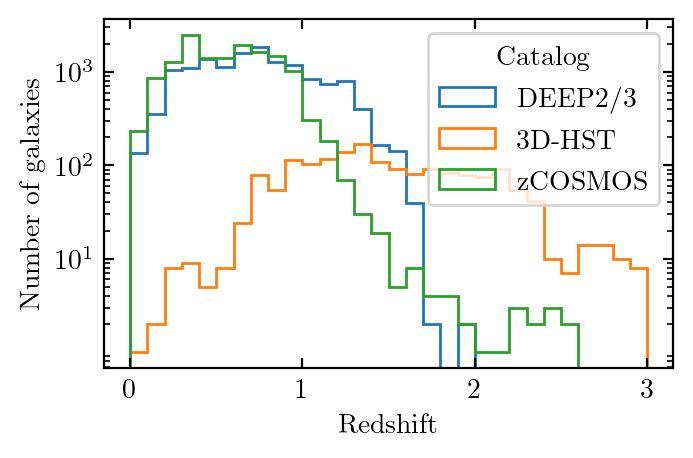

In [25]:
fig,ax = plt.subplots(figsize=(3.35,3.35*0.65),constrained_layout=True)

idx = np.where( catalog['source'] == 'DEEP2/3' )
ax.hist(catalog['redshift'][idx],range=(0,3),bins=30,histtype='step',label='DEEP2/3')
idx = np.where( catalog['source'] == '3D-HST' )
ax.hist(catalog['redshift'][idx],range=(0,3),bins=30,histtype='step',label='3D-HST')

ax.hist(cat['zpec'],range=(0,3),bins=30,histtype='step',label='zCOSMOS')

ax.legend(title="Catalog")

ax.set_xlabel('Redshift')
ax.set_ylabel('Number of galaxies')
ax.set_yscale('log')
ax.set_yticks([10,100,1000])
plt.show()

Redshift histogram per i-band magnitude

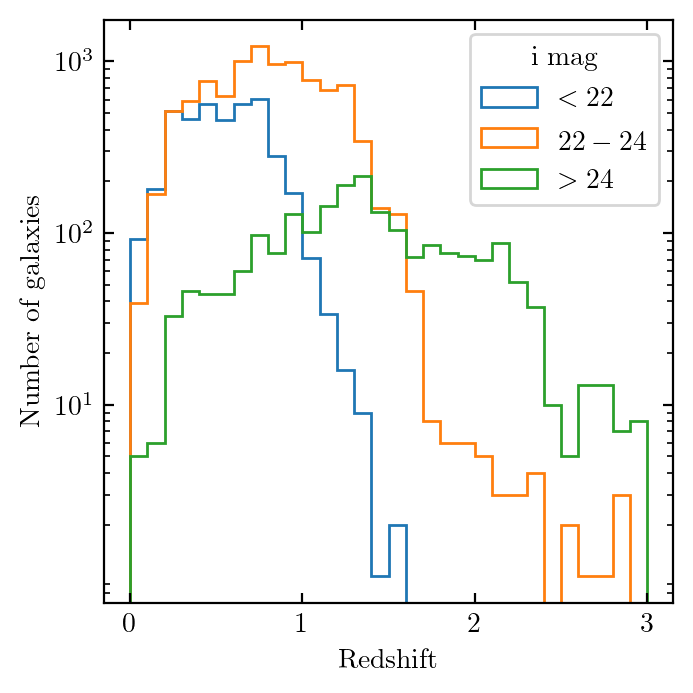

In [26]:
fig,ax = plt.subplots(constrained_layout=True)

idx = np.where( catalog['i'] <= 22 )
ax.hist(catalog['redshift'][idx],range=(0,3),bins=30,histtype='step',label='$<22$')
idx = np.where( ( catalog['i'] > 22 ) & ( catalog['i'] <= 24 ) )
ax.hist(catalog['redshift'][idx],range=(0,3),bins=30,histtype='step',label='$22-24$')
idx = np.where( catalog['i'] > 24 )
ax.hist(catalog['redshift'][idx],range=(0,3),bins=30,histtype='step',label='$>24$')

ax.legend(title='i mag')

ax.set_xlabel('Redshift')
ax.set_ylabel('Number of galaxies')
ax.set_yscale('log')
ax.set_yticks([10,100,1000])

plt.show()